![alt text](spacy.png "Title")

## Second method- used in Spacy libary

### so what is SpaCy?
<br>

#### spaCy is a library for advanced Natural Language Processing in Python and Cython. It's built on the very latest research, and was designed from day one to be used in real products. spaCy comes with pretrained statistical models and word vectors, and currently supports tokenization for 50+ languages. It features state-of-the-art speed, convolutional neural network models for tagging, parsing and named entity recognition and easy deep learning integration. It's commercial open-source software, released under the MIT license.
#### spaCy provides a variety of linguistic annotations that give us insights into a text’s grammatical structure. This includes the word types, like the parts of speech, and how the words are related to each other. 
<br>

##### for more information: [Documentation](https://spacy.io/)

<br>


### We chose to use Spacy to identify nouns and adjectives in each sentence of each review.<br>In this way we hope to find all the appropriate characteristics.

#### So lets start

In [2]:
##### First, we start with the imports that are mutual for both approaches
import os
import json
import gensim
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import string
import warnings
import pickle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

#Libraries for cleaning
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#Image load
import requests
from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#Spacy approach import

#Return a Language object containing all components and data needed to process text
nlp = spacy.load("en_core_web_sm")
from spacy import displacy


#### For this tutorial, we are using in Electronics dataset

In [4]:
INPUT='Electronics.json.gz'
LIMIT = 4000000

data = []
i=0
with gzip.open(INPUT) as f:

    for l in f:

        data.append(json.loads(l.strip()))
        i=i+1
        if i==LIMIT:
            break
print('Finished Loading data')     

Finished Loading data


In [5]:
df= pd.DataFrame.from_dict(data)

##### Cleaning The DataSet - Cleanup is done the same as in word2vec approach.

In [6]:
# remove punctuation 
def remove_punctuation(review): 
    translator = str.maketrans('', '', string.punctuation) 
    return review.translate(translator)

###### We will use the contraction file to turn terms such as "don't" into their formal form, in our example, "don't" will turn to "do not"

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

#Loading contraction file
contractions = json.load(open("contractions.json"))  

def SplitAndCleanReview(review):
    #converting all letters to lower case
    review=str(review)
    clean_review = review.lower()
    
    #Replacing the abbreviation with the long phrase
    clean_review = clean_review.split()
    new_review = []
    for word in clean_review:
        if word in contractions:
             new_review.append(contractions[word])
        else:
             new_review.append(word)
    clean_review = " ".join(new_review)
    #removing numbers
    clean_review = re.sub(r'\d+', '', clean_review)
    
    #split review to sentences
    review_sentences=(nltk.tokenize.sent_tokenize(clean_review))
    review_clean_sentences= []
    for i,sent in enumerate(review_sentences):
        if sent==[]:
            continue
        #removing punctuation
        sent = remove_punctuation(sent)
        #removing extra spaces
        sent = re.sub(r' +', ' ', sent)
        review_clean_sentences.append(nltk.word_tokenize(sent))

    
    return review_clean_sentences

In [8]:
#This dataset also contained book comments so we removed them
df=df[284:]
#remove 'nan' reviews
df=df[df['reviewText'] != 'nan']
#remove null reviews
df = df.dropna(subset=['reviewText'])
#remove duplicat
df = df.loc[:,~df.columns.duplicated()]
#columns that interests us
df = df[['asin', 'reviewText', 'overall']]

df.head()

,asin,reviewText,overall
284,0511189877,"This remote, for whatever reason, was chosen b...",2.0
285,0511189877,Dog got the old remote and destroyed it. Didn...,5.0
286,0511189877,We had an old Time Warner Cable remote that wa...,5.0
287,0511189877,This unit works just like the TEC unit only be...,5.0
288,0511189877,It is an exact duplicate of my Time warner rem...,5.0


Text(0.5, 1.0, 'Distribution of Ratings')

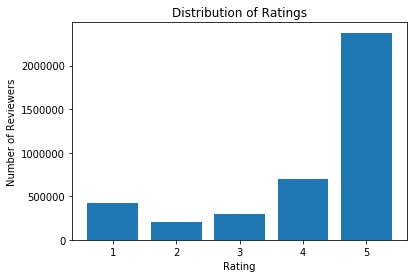

In [13]:
#Distribution of rating
df_rating = df.groupby(["overall"])["asin"].count().reset_index(name="count")

x = [rate for rate in df_rating['overall']]
y = [count for count in df_rating['count']]

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")

In [14]:
#Dataset containing reviews with high rate only
df_positive_reviews = df[df.overall > 3]
df_positive_reviews= df_positive_reviews.reset_index()
print("amount of positive reviews: ",df_positive_reviews.shape[0])

amount of positive reviews:  3080564


In [11]:
for i in range(3):
    print(df_positive_reviews["reviewText"][i],"\n")

Dog got the old remote and destroyed it.  Didn't feel like explaining to the folks at the Time Warner Cable office what happened.  Saw the price on Amazon for this one and chose the low hassle option.  It works perfectly.  Price was right. 

We had an old Time Warner Cable remote that was dropped into a bucket of dirty mop water.  We dried it out and it seemed to work "fine" except for the few times one of the batteries began to sizzle and smoke and became hotter than anything I had ever felt before and literally burned a hole in our couch upholstery.  Needless to say, this remote, the CLIKR-5, is awesome, easily programmed, and works perfectly with our TWC equipment and all the other A/V components.  I love this remote... great product.  (Probably goes without saying, but just in case, you don't get the TWC logo on it.) 

This unit works just like the TEC unit only better. I like it and would buy another if needed. OK? 



In [15]:
#Dataset containing reviews with low rate only
df_negative_reviews = df[df.overall < 3]
df_negative_reviews= df_negative_reviews.reset_index()
#df_negative_reviews.head()
print("amount of negative reviews: ",df_negative_reviews.shape[0])

amount of negative reviews:  625164


In [13]:
for i in range(3):
    print(df_negative_reviews["reviewText"][i],"\n")

This remote, for whatever reason, was chosen by Time Warner to replace their previous silver remote, the Time Warner Synergy V RC-U62CP-1.12S.  The actual function of this CLIKR-5 is OK, but the ergonomic design sets back remotes by 20 years.  The buttons are all the same, there's no separation of the number buttons, the volume and channel buttons are the same shape as the other buttons on the remote, and it all adds up to a crappy user experience.  Why would TWC accept this as a replacement?  This remote is virtually impossible to pick up and use without staring at it to make sure where your fingers are.  Heck, you have to feel around just to figure out if you've grabbed it by the top or bottom, since there's no articulation in the body of the thing to tell you which end is up.  Horrible, just horrible design.  I'm skipping this and paying double for a refurbished Synergy V. 

I have an older URC-WR7 remote and thought this would be an upgrade (and because TWC stuck me with it), but t

#### cleaning the reviews and spliting to list of clean sentences for each review

In [11]:
df_positive_reviews['reviewSentences']=df_positive_reviews['reviewText'].apply(SplitAndCleanReview)
df_positive_reviews.head()

,index,asin,reviewText,overall,reviewSentences
0,285,0511189877,Dog got the old remote and destroyed it. Didn...,5.0,"[[dog, got, the, old, remote, and, destroyed, ..."
1,286,0511189877,We had an old Time Warner Cable remote that wa...,5.0,"[[we, had, an, old, time, warner, cable, remot..."
2,287,0511189877,This unit works just like the TEC unit only be...,5.0,"[[this, unit, works, just, like, the, tec, uni..."
3,288,0511189877,It is an exact duplicate of my Time warner rem...,5.0,"[[it, is, an, exact, duplicate, of, my, time, ..."
4,289,0511189877,Exactly what I needed and what I ordered.,5.0,"[[exactly, what, i, needed, and, what, i, orde..."


In [15]:
for i in range(3):
    for j in range(0,len(df_positive_reviews["reviewSentences"][i])):
        print(df_positive_reviews["reviewSentences"][i][j])
    print("\n")    

['dog', 'got', 'the', 'old', 'remote', 'and', 'destroyed', 'it']
['did', 'not', 'feel', 'like', 'explaining', 'to', 'the', 'folks', 'at', 'the', 'time', 'warner', 'cable', 'office', 'what', 'happened']
['saw', 'the', 'price', 'on', 'amazon', 'for', 'this', 'one', 'and', 'chose', 'the', 'low', 'hassle', 'option']
['it', 'works', 'perfectly']
['price', 'was', 'right']


['we', 'had', 'an', 'old', 'time', 'warner', 'cable', 'remote', 'that', 'was', 'dropped', 'into', 'a', 'bucket', 'of', 'dirty', 'mop', 'water']
['we', 'dried', 'it', 'out', 'and', 'it', 'seemed', 'to', 'work', 'fine', 'except', 'for', 'the', 'few', 'times', 'one', 'of', 'the', 'batteries', 'began', 'to', 'sizzle', 'and', 'smoke', 'and', 'became', 'hotter', 'than', 'anything', 'i', 'had', 'ever', 'felt', 'before', 'and', 'literally', 'burned', 'a', 'hole', 'in', 'our', 'couch', 'upholstery']
['needless', 'to', 'say', 'this', 'remote', 'the', 'clikr', 'is', 'awesome', 'easily', 'programmed', 'and', 'works', 'perfectly', 'wi

In [12]:
df_negative_reviews['reviewSentences']=df_negative_reviews['reviewText'].apply(SplitAndCleanReview)
df_positive_reviews.head()

,index,asin,reviewText,overall,reviewSentences
0,285,0511189877,Dog got the old remote and destroyed it. Didn...,5.0,"[[dog, got, the, old, remote, and, destroyed, ..."
1,286,0511189877,We had an old Time Warner Cable remote that wa...,5.0,"[[we, had, an, old, time, warner, cable, remot..."
2,287,0511189877,This unit works just like the TEC unit only be...,5.0,"[[this, unit, works, just, like, the, tec, uni..."
3,288,0511189877,It is an exact duplicate of my Time warner rem...,5.0,"[[it, is, an, exact, duplicate, of, my, time, ..."
4,289,0511189877,Exactly what I needed and what I ordered.,5.0,"[[exactly, what, i, needed, and, what, i, orde..."


In [17]:
for i in range(3):
    for j in range(0,len(df_negative_reviews["reviewSentences"][i])):
        print(df_negative_reviews["reviewSentences"][i][j])
    print("\n")    

['this', 'remote', 'for', 'whatever', 'reason', 'was', 'chosen', 'by', 'time', 'warner', 'to', 'replace', 'their', 'previous', 'silver', 'remote', 'the', 'time', 'warner', 'synergy', 'v', 'rcucps']
['the', 'actual', 'function', 'of', 'this', 'clikr', 'is', 'ok', 'but', 'the', 'ergonomic', 'design', 'sets', 'back', 'remotes', 'by', 'years']
['the', 'buttons', 'are', 'all', 'the', 'same', 'there', 'is', 'no', 'separation', 'of', 'the', 'number', 'buttons', 'the', 'volume', 'and', 'channel', 'buttons', 'are', 'the', 'same', 'shape', 'as', 'the', 'other', 'buttons', 'on', 'the', 'remote', 'and', 'it', 'all', 'adds', 'up', 'to', 'a', 'crappy', 'user', 'experience']
['why', 'would', 'twc', 'accept', 'this', 'as', 'a', 'replacement']
['this', 'remote', 'is', 'virtually', 'impossible', 'to', 'pick', 'up', 'and', 'use', 'without', 'staring', 'at', 'it', 'to', 'make', 'sure', 'where', 'your', 'fingers', 'are']
['heck', 'you', 'have', 'to', 'feel', 'around', 'just', 'to', 'figure', 'out', 'if', '

<br>

_______________________________________________________________________________________________________________________________

<br>

In [9]:
#please run this
with open("spacy_sentences_visualization.txt", mode='rb') as file:
    spacy_sentences_visualization = pickle.load(file)

### A little taste of SpaCy's power

In [10]:
#Spacy visualization reviews example
for rev in spacy_sentences_visualization:
    for sen in rev:
        sentence= " ".join(sen)
        doc = nlp(sentence)
        displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [11]:
#The same reviews after removing stopWords
for rev in spacy_sentences_visualization:
    for sen in rev:
        doc = nlp(" ".join(sen))        
        sentence = [token.text for token in doc if token.is_stop==False]
        doc = nlp(" ".join(sentence))  
        displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

<br>

_______________________________________________________________________________________________________________________________

#### Note: <br> Also in this approach, We  removed StopWord because it seems that Spacy recognizes  the adjectives and adverbs in each sentence quite well without them. Our goal is to reduce the characteristics so that they will be as focused as possible

In [88]:
#ourstopword contains stopwords without negative words 
OUR_STOP_WORDS =STOP_WORDS

for i in ['except','not','cannot','nor','nothing','neither','none','no','never','off','nowhere','but','however','else','nobody','empty']:
    OUR_STOP_WORDS.remove(i)   

In [13]:
OUR_STOP_WORDS=set(OUR_STOP_WORDS)

#### Each sentence in each comment is sent to the function below.<br> There, we iterate over the tokens in the sentence doc.<br>If Spacy identified a adjective or adverb then any possible combination in size 3  will be tested because Only tuples that also contain a noun will be taken.

In [14]:
#Function that returns all possible combinations in size k in a single sentence, that contain Adjective-Adverb and noun. 
#The Adjective\Adverb and noun indentify by spacy
def getSentenceTuple(sentence,k):
    
    #Remove stopWords except negative words
    sentence=[word for word in sentence if word not in OUR_STOP_WORDS]
    #Return a processed Doc for sentence
    doc=nlp(" ".join(sentence))
    words=[str(t) for t in doc]
    #Set of all the noun spacy identify in doc 
    set_noun= set([nc.text for nc in doc if nc.pos_ =="NOUN"])
    sentence_tuple=set()
    
    for i,token in enumerate(doc):
        if token.pos_ not in ["ADJ", "ADV"]:
            continue
        min_j= max([0,i-k+1])
        max_j= min([len(doc)-k,i])
        for j in range(min_j,max_j+1,1):
            tuple_j= tuple(words[j:j+k])
            if any(word in set_noun for word in tuple_j):
                sentence_tuple.add(tuple_j)
                
    return sentence_tuple

In [15]:
#Function returns a dictionary whose keys are sequences with adjectives\adverbs and noun  
#The value of each key is the number of times it appears in all the reviews
def getDictionaryAdvAndAdj(reviews, k=3):

    tuples_count={}
    log_message=10000

    for i,review in enumerate(reviews):

        if i%log_message ==0:
            print("log_message: ",i)
            
        review_tuples=set()
        for sentence in review:
            review_tuples |= set(getSentenceTuple(sentence, k))
            
        for word_tup in review_tuples:
            tuples_count[word_tup]= tuples_count.get(word_tup,0)+1

    return tuples_count

In [16]:
#create a dicionary for the positive reviews tuples
#spacy_electronics_positive_tuples_count= getDictionaryAdvAndAdj(df_positive_reviews['reviewSentences'])

In [19]:
#printing the head 100
for i,key in enumerate(spacy_electronics_positive_tuples_count.keys()):
    if i==150:
        break
    print(key)

('chose', 'low', 'hassle')
('low', 'hassle', 'option')
('easily', 'programmed', 'works')
('love', 'remote', 'great')
('programmed', 'works', 'perfectly')
('remote', 'great', 'product')
('fine', 'except', 'times')
('works', 'perfectly', 'twc')
('literally', 'burned', 'hole')
('tec', 'unit', 'better')
('easy', 'program', 'tv')
('able', 'program', 'device')
('spare', 'trick', 'works')
('trick', 'works', 'great')
('needed', 'spare', 'trick')
('set', 'easy', 'works')
('no', 'problem', 'far')
('easy', 'works', 'got')
('able', 'original', 'remote')
('original', 'remote', 'correctly')
('tv', 'never', 'able')
('volume', 'tv', 'never')
('work', 'great', 'love')
('bright', 'house', 'networks')
('came', 'bright', 'house')
('great', 'like', 'controller')
('perfectly', 'twc', 'box')
('exactly', 'except', 'silver')
('replacement', 'broke', 'original')
('red', 'background', 'display')
('broke', 'original', 'controller')
('original', 'controller', 'given')
('works', 'great', 'like')
('tv', 'able', 'use

In [21]:
#create a dicionary for the negative reviews tuples
#spacy_electronics_negative_tuples_count= getDictionaryAdvAndAdj(df_negative_reviews['reviewSentences'])

log_message:  0
log_message:  10000
log_message:  20000
log_message:  30000
log_message:  40000
log_message:  50000
log_message:  60000
log_message:  70000
log_message:  80000
log_message:  90000
log_message:  100000
log_message:  110000
log_message:  120000
log_message:  130000
log_message:  140000
log_message:  150000
log_message:  160000
log_message:  170000
log_message:  180000
log_message:  190000
log_message:  200000
log_message:  210000
log_message:  220000
log_message:  230000
log_message:  240000
log_message:  250000
log_message:  260000
log_message:  270000
log_message:  280000
log_message:  290000
log_message:  300000
log_message:  310000
log_message:  320000
log_message:  330000
log_message:  340000
log_message:  350000
log_message:  360000
log_message:  370000
log_message:  380000
log_message:  390000
log_message:  400000
log_message:  410000
log_message:  420000
log_message:  430000
log_message:  440000
log_message:  450000
log_message:  460000
log_message:  470000
log_me

In [22]:
#printing the head 100
for i,key in enumerate(spacy_electronics_negative_tuples_count.keys()):
    if i==150:
        break
    print(key)

('virtually', 'impossible', 'pick')
('silver', 'remote', 'time')
('impossible', 'pick', 'use')
('staring', 'sure', 'fingers')
('use', 'staring', 'sure')
('adds', 'crappy', 'user')
('remote', 'reason', 'chosen')
('remote', 'time', 'warner')
('horrible', 'horrible', 'design')
('actual', 'function', 'clikr')
('double', 'refurbished', 'synergy')
('but', 'ergonomic', 'design')
('ergonomic', 'design', 'sets')
('crappy', 'user', 'experience')
('biggest', 'problem', 'streaming')
('yellow', 'green', 'buttons')
('old', 'remote', 'head')
('remote', 'head', 'head')
('need', 'hit', 'blue')
('know', 'multiple', 'code')
('multiple', 'code', 'methods')
('pull', 'remote', 'setting')
('program', 'tv', 'properly')
('normal', 'return', 'label')
('included', 'normal', 'return')
('remote', 'but', 'none')
('reach', 'new', 'exchange')
('stubborn', 'button', 'button')
('right', 'achieve', 'liftoff')
('weeks', 'inevitably', 'random')
('hold', 'nose', 'right')
('nose', 'right', 'achieve')
('random', 'keys', 'beg

In [17]:
with open('Electronics/spacy/electronics_spacy_positive_tuples_count.txt',mode='r') as f:
            spacy_electronics_positive_tuples_count = json.load(f)

electronics_negative_tuples_count={}
with open('Electronics/spacy/electronics_spacy_negative_tuples_count.txt',mode='r') as f:
            spacy_electronics_negative_tuples_count = json.load(f)        

In [18]:
#Creating a dictionary whose key is a tuple.
#the value of each key is a set that contains the incidence of the tuple in positive responses, and negative responses
def TopList(positive_tuples_count,negative_tuples_count,amount_positive_reviews,amount_negative_reviews,top_num):

    all_tuples= set(positive_tuples_count)|set(negative_tuples_count)
    
    tuple_scores = {}

    for word_tup in all_tuples:
        positive_score = positive_tuples_count.get(word_tup,0)/amount_positive_reviews
        negative_score = negative_tuples_count.get(word_tup,0)/amount_negative_reviews
        tuple_scores[word_tup] = (positive_score,negative_score)
        
    #The tuples that appear relatively more in positive reviews
    top_positive= sorted(tuple_scores.items(),key = lambda t: t[1][0], reverse = True)[:top_num]
    #The tuples that appear relatively more in negative reviews
    top_negative= sorted(tuple_scores.items(),key = lambda t: t[1][1], reverse = True)[:top_num]    
    
    return top_positive,top_negative

In [22]:
#The tuples that appear relatively more in Electronics positive reviews and negative reviews
electronics_amount_positive_reviews= df_positive_reviews.shape[0]
electronics_amount_negative_reviews= df_negative_reviews.shape[0]
spacy_electronics_top_positive, spacy_electronics_top_negative = TopList(spacy_electronics_positive_tuples_count,spacy_electronics_negative_tuples_count,electronics_amount_positive_reviews,electronics_amount_negative_reviews,20)

In [23]:
spacy_electronics_top_positive

[("('not', 'big', 'deal')", (0.0031536432938903394, 0.0014156285390713476)),
 ("('highly', 'recommend', 'product')",
  (0.00299036150523086, 5.598530945479906e-05)),
 ("('sound', 'quality', 'good')",
  (0.002877395178285535, 0.0018795068174111114)),
 ("('external', 'hard', 'drive')",
  (0.0020045030715154758, 0.0020730560300977023)),
 ("('sound', 'quality', 'great')",
  (0.0019723660991948226, 0.0007358069242630734)),
 ("('good', 'sound', 'quality')",
  (0.0019272444915930979, 0.0011389011523376266)),
 ("('great', 'sound', 'quality')",
  (0.001708778002989063, 0.0005886455394104587)),
 ("('product', 'great', 'price')",
  (0.0017055318441687951, 4.9586988374250597e-05)),
 ("('great', 'product', 'great')",
  (0.0016389855883533015, 3.359118567287944e-05)),
 ("('no', 'big', 'deal')", (0.001333197427484058, 0.0008861674696559623)),
 ("('sound', 'quality', 'excellent')",
  (0.0012760650322473418, 0.0003391110172690686)),
 ("('product', 'works', 'great')",
  (0.0012302941928815632, 0.0001775

In [24]:
spacy_electronics_top_negative

[("('not', 'worth', 'money')", (9.83586122541197e-05, 0.004629185301776814)),
 ("('total', 'waste', 'money')",
  (1.4932330573232694e-05, 0.002108246796040719)),
 ("('external', 'hard', 'drive')",
  (0.0020045030715154758, 0.0020730560300977023)),
 ("('not', 'work', 'properly')",
  (0.00019412029745202502, 0.0019882782757804354)),
 ("('complete', 'waste', 'money')",
  (1.4932330573232694e-05, 0.001970682892808927)),
 ("('sound', 'quality', 'not')", (0.0008767874973543805, 0.00195788625064783)),
 ("('not', 'worth', 'time')", (4.771853465793926e-05, 0.001941890447946459)),
 ("('sound', 'quality', 'good')",
  (0.002877395178285535, 0.0018795068174111114)),
 ("('not', 'worth', 'price')", (7.303857345602948e-05, 0.0016123769122982129)),
 ("('not', 'able', 'use')", (0.00045381300307346316, 0.0015100037750094375)),
 ("('not', 'worth', 'hassle')",
  (4.479699171969808e-05, 0.0014572176260949127)),
 ("('quality', 'not', 'good')",
  (0.00035707747022947745, 0.0014412218233935416)),
 ("('not', 'b

In [25]:
def VisualizingTopTuples(pos_neg,top):
    
    x = [str(tup[0]) for tup in top]
    y = [incidence[1][pos_neg] for incidence in top]
    
    # Create a dataframe
    visualize_df = pd.DataFrame({'tuples': x, 'frequencies': y })

    # Reorder it following the values:
    ordered_df = visualize_df.sort_values(by='frequencies')
    my_range = range(1,len(visualize_df.index)+1)

    # The vertival plot is made using the hline function
    plt.hlines(y=my_range, xmin=0, xmax=ordered_df['frequencies'], color='skyblue')
    plt.plot(ordered_df['frequencies'], my_range, "o")

    # Add titles and axis names
    plt.yticks(my_range, ordered_df['tuples'])
    plt.title("Tuple frequencies", loc='left')
    plt.xlabel('frequencies')
    plt.ylabel('tuples')

#### As we can see in our top positive tuples result, we get tuples such as ('sound', 'quality', 'good') and ('batery', 'life', 'good') that helps us to understand some of the positive general characteristics of the Electronics category.

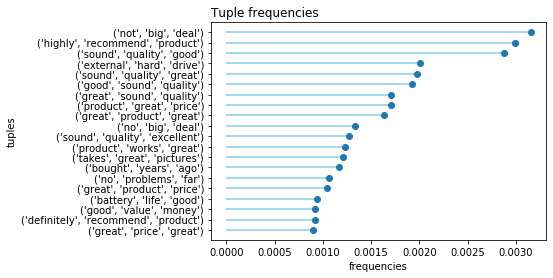

In [26]:
#Visualizing top positive Electronics
VisualizingTopTuples(0,spacy_electronics_top_positive)

#### We can see that there are tuples such as (sound, quality, good) and (poor, sound, quality) that imply that there is a conflict in the negative reviews about the sound quality in the products category.

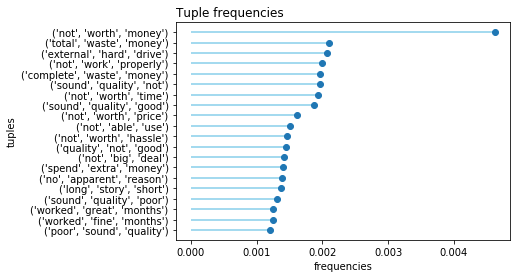

In [27]:
#Visualizing top negative Electronics
VisualizingTopTuples(1,spacy_electronics_top_negative)

In [28]:
#Displaying the prevalence for each top 20 tuples in the negative and positive dictionaries
def VisualizingTopTuplesNegative_Positive(top_positive,top_negative):
    
    Xpos_positive = [tup[1][0] for tup in top_positive]
    Yneg_positive = [tup[1][1] for tup in top_positive]

    Xpos_negative = [tup[1][0] for tup in top_negative]
    Yneg_negative = [tup[1][1] for tup in top_negative]

    plt.xlabel('Prevalence in the positive tuple count')
    plt.ylabel('Prevalence in the negative tuple count')
    
    sns.regplot(x=Xpos_positive, y=Yneg_positive, fit_reg=False)
    sns.regplot(x=Xpos_negative, y=Yneg_negative, fit_reg=False)

    plt.show()

#### Some combinations appear in both lists, the positive and the negative, and even in the top lists

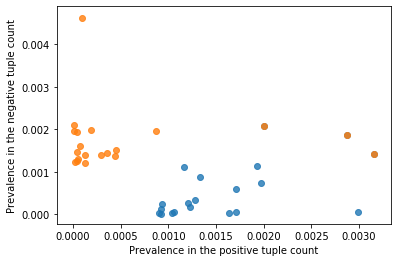

In [29]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Electronics dictionaries
VisualizingTopTuplesNegative_Positive(spacy_electronics_top_positive,spacy_electronics_top_negative)

<br>

_______________________________________________________________________________________________________________________________

#### As we did for the electronic product category, we also did this for other categories, Cellphones and Automotive.
##### Note:<br>In order for the tutorial to be focused, from now on, we will only display the results and comparisons, but the full notebooks listed in the attachments can be viewed.

<br>

### Cellphones and Accessories

In [30]:
with open('Cellphones/spacy/cellphones_spacy_positive_tuples_count.txt',mode='r') as f:
            spacy_cellphones_positive_tuples_count = json.load(f)
        

with open('Cellphones/spacy/cellphones_spacy_negative_tuples_count.txt',mode='r') as f:
            spacy_cellphones_negative_tuples_count = json.load(f)      

In [31]:
#The tuples that appear relatively more in Cellphones positive reviews and negative reviews
cellphones_amount_positive_reviews = 1410282
cellphones_amount_negative_reviews = 401685
spacy_cellphones_top_positive, spacy_cellphones_top_negative = TopList(spacy_cellphones_positive_tuples_count,spacy_cellphones_negative_tuples_count,cellphones_amount_positive_reviews,cellphones_amount_negative_reviews,20)

In [32]:
spacy_cellphones_top_positive

[("('fits', 'phone', 'perfectly')",
  (0.004527463301665908, 0.0002589093443867707)),
 ("('highly', 'recommend', 'product')",
  (0.003219923391208283, 2.4895129267958725e-05)),
 ("('not', 'big', 'deal')", (0.0031085981385283227, 0.0010879171490097961)),
 ("('case', 'fits', 'perfectly')",
  (0.002222250585343924, 0.0001443917497541606)),
 ("('highly', 'recommend', 'case')",
  (0.002130779517855294, 3.236366804834634e-05)),
 ("('great', 'product', 'great')",
  (0.0019208924172612286, 1.7426590487571107e-05)),
 ("('product', 'great', 'price')",
  (0.001842184754538454, 3.236366804834634e-05)),
 ("('definitely', 'recommend', 'product')",
  (0.0015904620494340848, 1.4937077560775234e-05)),
 ("('fit', 'phone', 'perfectly')",
  (0.001540117508413211, 0.00031118911584948405)),
 ("('add', 'bulk', 'phone')", (0.0014394284263714633, 0.00014190223682736472)),
 ("('feels', 'good', 'hand')", (0.0014004291340313497, 0.0001792449307293028)),
 ("('great', 'job', 'protecting')",
  (0.0013288122517340505

In [33]:
spacy_cellphones_top_negative

[("('not', 'fit', 'phone')", (0.000692769247568926, 0.010804486102294087)),
 ("('case', 'not', 'fit')", (0.0006069708044206762, 0.006721684902348856)),
 ("('not', 'worth', 'money')", (5.3889931233611435e-05, 0.005942467356261747)),
 ("('phone', 'not', 'fit')", (0.0004814639908897653, 0.002613988573135666)),
 ("('total', 'waste', 'money')",
  (1.5599716936045417e-05, 0.0020588271904601863)),
 ("('complete', 'waste', 'money')",
  (1.1345248680760302e-05, 0.0019592466733883516)),
 ("('not', 'worth', 'time')", (2.5526809531710678e-05, 0.0018671346950969042)),
 ("('not', 'able', 'use')", (0.00038857476731604033, 0.0016555260963192551)),
 ("('not', 'good', 'quality')",
  (0.00012054326723307821, 0.001600756811929746)),
 ("('not', 'work', 'properly')",
  (0.00011557972093524557, 0.0015683931438813996)),
 ("('not', 'worth', 'price')", (3.332666799973339e-05, 0.001481260191443544)),
 ("('not', 'good', 'product')",
  (3.049035582954331e-05, 0.0013891482131520969)),
 ("('not', 'happy', 'product')

#### We got some really good results here, we can see that the results show us clear characteristics of the Cellphones and Accessories category 

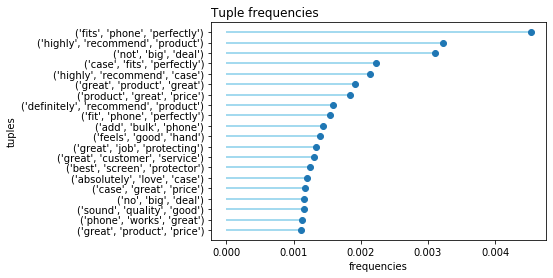

In [34]:
#Visualizing top positive Cellphones
VisualizingTopTuples(0,spacy_cellphones_top_positive)

#### The results here are more general compare to the top positive tuples, but it makes sense because we analyze a full category and not a specific product.

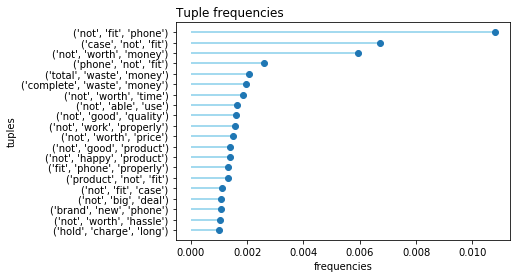

In [35]:
#Visualizing top negative Cellphones
VisualizingTopTuples(1,spacy_cellphones_top_negative)

#### Some of the negative combinations appear in the positive combinations, like the tuple ('not', 'big', 'deal'). 

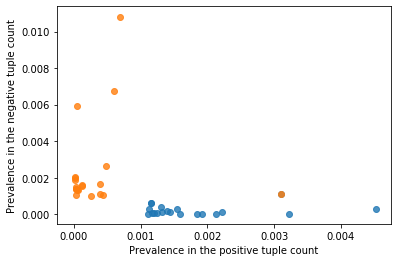

In [37]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Cellphones dictionaries
VisualizingTopTuplesNegative_Positive(spacy_cellphones_top_positive,spacy_cellphones_top_negative)

<br>

<br>

### Automotive

In [38]:
with open('Automotive/spacy/automotive_spacy_positive_tuples_count.txt',mode='r') as f:
            spacy_automotive_positive_tuples_count = json.load(f)
        
with open('Automotive/spacy/automotive_spacy_negative_tuples_count.txt',mode='r') as f:
            spacy_automotive_negative_tuples_count = json.load(f)      

In [39]:
#The tuples that appear relatively more in Automotive positive reviews and negative reviews
automotive_amount_positive_reviews = 3269721
automotive_amount_negative_reviews = 477639
spacy_automotive_top_positive, spacy_automotive_top_negative = TopList(spacy_automotive_positive_tuples_count,spacy_automotive_negative_tuples_count,automotive_amount_positive_reviews,automotive_amount_negative_reviews,20)

In [40]:
spacy_automotive_top_positive

[("('highly', 'recommend', 'product')",
  (0.0019686694981009083, 3.3498102123151586e-05)),
 ("('easy', 'install', 'works')",
  (0.001953377673507923, 4.1872627653939485e-05)),
 ("('great', 'product', 'great')",
  (0.0017597831741607312, 2.9310839357757637e-05)),
 ("('product', 'great', 'price')",
  (0.0017463263685189043, 4.81535218020304e-05)),
 ("('great', 'easy', 'install')",
  (0.0016041123998041423, 0.00010886883190024265)),
 ("('super', 'easy', 'install')",
  (0.0015640478193705211, 6.071531009821225e-05)),
 ("('not', 'big', 'deal')", (0.001315096914996723, 0.0008395461844614866)),
 ("('easy', 'install', 'looks')",
  (0.001258517164002678, 7.537072977709107e-05)),
 ("('local', 'auto', 'parts')",
  (0.0011973498656307373, 0.0013566731359876392)),
 ("('product', 'easy', 'install')",
  (0.0011010113706949307, 7.537072977709107e-05)),
 ("('fit', 'easy', 'install')", (0.001045349129176465, 5.65280473328183e-05)),
 ("('install', 'works', 'great')",
  (0.0010043670392672647, 1.46554196

In [41]:
spacy_automotive_top_negative

[("('not', 'fit', 'car')", (0.0002520092692923953, 0.0051670822524961324)),
 ("('not', 'worth', 'money')", (2.9971976202250896e-05, 0.004367315064305888)),
 ("('not', 'fit', 'vehicle')",
  (0.00010765444513461546, 0.0022066874773626105)),
 ("('product', 'not', 'fit')", (6.575484574983615e-05, 0.002173189375239459)),
 ("('total', 'waste', 'money')",
  (7.034239312773169e-06, 0.0017900548322059128)),
 ("('complete', 'waste', 'money')",
  (7.340075804632873e-06, 0.00154300632904767)),
 ("('not', 'worth', 'time')", (2.8136957251092676e-05, 0.0014069202891723665)),
 ("('local', 'auto', 'parts')",
  (0.0011973498656307373, 0.0013566731359876392)),
 ("('spend', 'extra', 'money')",
  (0.00013456805641826934, 0.0013210814024817907)),
 ("('not', 'good', 'quality')",
  (5.5356405026606245e-05, 0.0012478043040873965)),
 ("('not', 'worth', 'price')",
  (1.8656026003441885e-05, 0.0011787144684583964)),
 ("('not', 'good', 'product')",
  (2.2020227413898618e-05, 0.0011159055269774872)),
 ("('not', 'ha

#### We can see that the results show us clear characteristics of the Automotive, such as ('super', 'easy', 'install') and ('great','product','fast')

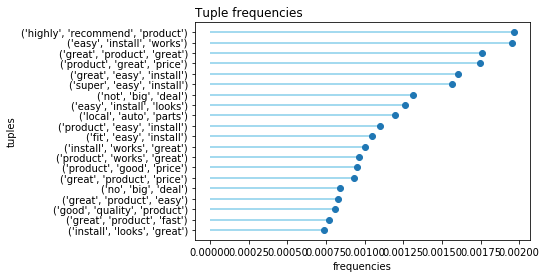

In [42]:
#Visualizing top positive Automotive
VisualizingTopTuples(0,spacy_automotive_top_positive)

#### It seems that maybe the positive general characteristics are more prevalent than the negative characteristics, and that's why we don't see something interesting.

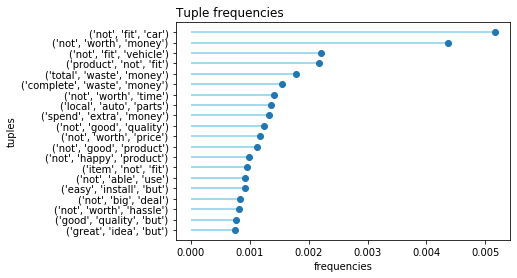

In [43]:
#Visualizing top negative Automotive
VisualizingTopTuples(1,spacy_automotive_top_negative)

#### Here as well, Some of the negative combinations appear in the positive combinations, like the tuple ('not', 'big', 'deal'). 

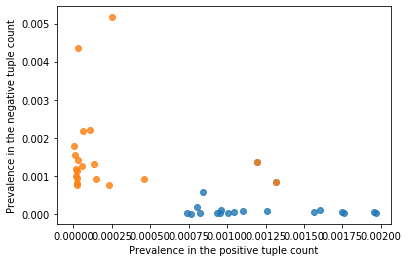

In [44]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Automotive dictionaries
VisualizingTopTuplesNegative_Positive(spacy_automotive_top_positive,spacy_automotive_top_negative)

<br>

_______________________________________________________________________________________________________________________________

### After reviewing each category separately, we will now compare the positive combinations between categories and negative combinations

#### We can see that there's an overlap between the top positive tuples of the different categories.

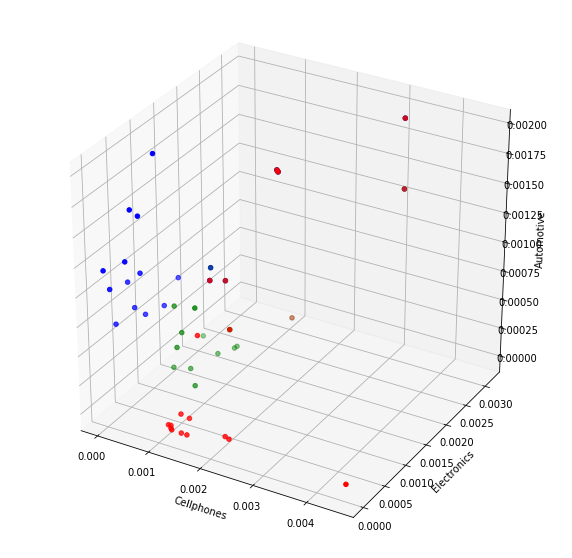

In [45]:
#Positive

Xpos_cellphones = [tup[1][0] for tup in spacy_cellphones_top_positive]
Ypos_cellphones = [((spacy_electronics_positive_tuples_count.get(tup[0],0))/electronics_amount_positive_reviews) for tup in spacy_cellphones_top_positive]
Zpos_cellphones = [((spacy_automotive_positive_tuples_count.get(tup[0],0))/automotive_amount_positive_reviews) for tup in spacy_cellphones_top_positive]

Xpos_electronics = [((spacy_cellphones_positive_tuples_count.get(tup[0],0))/cellphones_amount_positive_reviews) for tup in spacy_electronics_top_positive]
Ypos_electronics = [tup[1][0] for tup in spacy_electronics_top_positive]
Zpos_electronics = [((spacy_automotive_positive_tuples_count.get(tup[0],0))/automotive_amount_positive_reviews) for tup in spacy_electronics_top_positive]

Xpos_automotive = [((spacy_cellphones_positive_tuples_count.get(tup[0],0))/cellphones_amount_positive_reviews) for tup in spacy_automotive_top_positive]
Ypos_automotive = [((spacy_electronics_positive_tuples_count.get(tup[0],0))/electronics_amount_positive_reviews) for tup in spacy_automotive_top_positive]
Zpos_automotive = [tup[1][0] for tup in spacy_automotive_top_positive]


category_comparison_plot = plt.figure(figsize=(10,10)).gca(projection='3d')
category_comparison_plot.scatter(Xpos_cellphones, Ypos_cellphones, Zpos_cellphones, color="r")
category_comparison_plot.scatter(Xpos_electronics, Ypos_electronics, Zpos_electronics, color="g")
category_comparison_plot.scatter(Xpos_automotive, Ypos_automotive, Zpos_automotive, color="b")
category_comparison_plot.set_xlabel('Cellphones')
category_comparison_plot.set_ylabel('Electronics')
category_comparison_plot.set_zlabel('Automotive')

plt.show()

#### We can see that there's an overlap between the top negative tuples of the different categories.

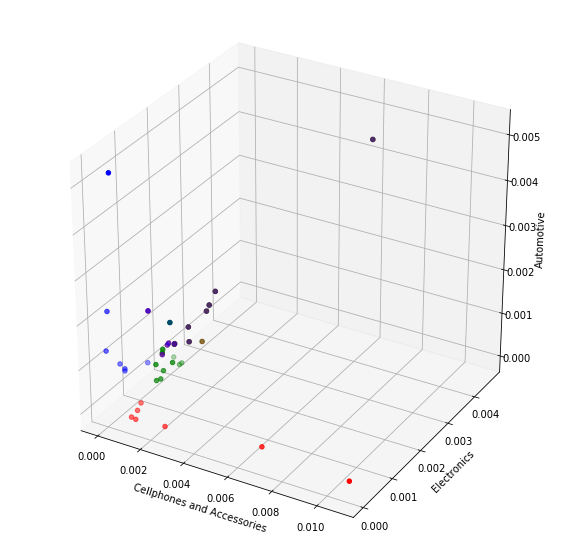

In [46]:
#Negative

Xneg_cellphones = [tup[1][1] for tup in spacy_cellphones_top_negative]
Yneg_cellphones = [((spacy_electronics_negative_tuples_count.get(tup[0],0))/electronics_amount_negative_reviews) for tup in spacy_cellphones_top_negative]
Zneg_cellphones = [((spacy_automotive_negative_tuples_count.get(tup[0],0))/automotive_amount_negative_reviews) for tup in spacy_cellphones_top_negative]

Xneg_electronics = [((spacy_cellphones_negative_tuples_count.get(tup[0],0))/cellphones_amount_negative_reviews) for tup in spacy_electronics_top_negative]
Yneg_electronics = [tup[1][1] for tup in spacy_electronics_top_negative]
Zneg_electronics = [((spacy_automotive_negative_tuples_count.get(tup[0],0))/automotive_amount_negative_reviews) for tup in spacy_electronics_top_negative]

Xneg_automotive = [((spacy_cellphones_negative_tuples_count.get(tup[0],0))/cellphones_amount_negative_reviews) for tup in spacy_automotive_top_negative]
Yneg_automotive = [((spacy_electronics_negative_tuples_count.get(tup[0],0))/electronics_amount_negative_reviews) for tup in spacy_automotive_top_negative]
Zneg_automotive = [tup[1][1] for tup in spacy_automotive_top_negative]

category_comparison_plot = plt.figure(figsize=(10,10)).gca(projection='3d')
category_comparison_plot.scatter(Xneg_cellphones, Yneg_cellphones, Zneg_cellphones, color="r")
category_comparison_plot.scatter(Xneg_electronics, Yneg_electronics, Zneg_electronics, color="g")
category_comparison_plot.scatter(Xneg_automotive, Yneg_automotive, Zneg_automotive, color="b")
category_comparison_plot.set_xlabel('Cellphones and Accessories')
category_comparison_plot.set_ylabel('Electronics')
category_comparison_plot.set_zlabel('Automotive')

plt.show()

<br>

_______________________________________________________________________________________________________________________________

<br>

### Test on specific products from each category

#### Now let's see if we were able to find the properties. We will test this for a specific product for each category


<br>
<br>

### Cellphones

In [47]:
#Loading Cellphones specific product data

cellphones_spec_df = pd.read_pickle("Cellphones\spacy\specific\cellphones_specific_product.pickle")
cellphones_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B005NF5NTK,I got this product for my mom since she replac...,5.0,NaN,"[[i, got, this, product, for, my, mom, since, ..."
1,B005NF5NTK,"it charges my LG ""dumb"" phone, my echo ecigs, ...",5.0,NaN,"[[it, charges, my, lg, dumb, phone, my, echo, ..."
2,B005NF5NTK,"As I received a use in my mobile, and I was ou...",5.0,NaN,"[[as, i, received, a, use, in, my, mobile, and..."
3,B005NF5NTK,Very compact but able to almost fully charge a...,5.0,NaN,"[[very, compact, but, able, to, almost, fully,..."
4,B005NF5NTK,"Charged my HTC Amaze 4G to 75%, with it being ...",4.0,NaN,"[[charged, my, htc, amaze, g, to, with, it, be..."


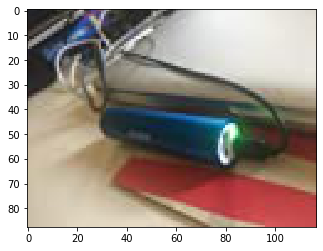

In [48]:
#Displaying product image

cellphones_image_df = cellphones_spec_df.dropna(subset=['image'])
cellphones_image_df = cellphones_image_df.reset_index()

response = requests.get(cellphones_image_df.image[2][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [49]:
#Dataset containing reviews with high rate only
cellphones_spec_pos_df = cellphones_spec_df[cellphones_spec_df.overall > 3]
cellphones_spec_pos_df= cellphones_spec_pos_df.reset_index()
print(cellphones_spec_pos_df.shape[0])

11245


In [50]:
#Dataset containing reviews with low rate only
cellphones_spec_neg_df = cellphones_spec_df[cellphones_spec_df.overall < 3]
cellphones_spec_neg_df= cellphones_spec_neg_df.reset_index()
print(cellphones_spec_neg_df.shape[0])

1354


In [51]:
#Loading Cellphones specific product dictionary positive files
with open('Cellphones/spacy/specific/cellphone_specific_product_spacy_positive_tuples_count.txt',mode='r') as pos_file:
    spacy_cellphones_spec_pos_tuples_count = json.load(pos_file)

In [52]:
#Loading Cellphones specific product dictionary negative files 
with open('Cellphones/spacy/specific/cellphone_specific_product_spacy_negative_tuples_count.txt',mode='r') as f:
            spacy_cellphones_spec_neg_tuples_count = json.load(f)    

In [53]:
#The tuples that appear relatively more in positive reviews and negative reviews
cellphones_spec_pos_amount_reviews = cellphones_spec_pos_df.shape[0]
cellphones_spec_neg_amount_reviews = cellphones_spec_neg_df.shape[0]
spacy_cellphones_spec_top_positive, spacy_cellphones_spec_top_negative = TopList(spacy_cellphones_spec_pos_tuples_count,spacy_cellphones_spec_neg_tuples_count,cellphones_spec_pos_amount_reviews,cellphones_spec_neg_amount_reviews,20)

In [54]:
spacy_cellphones_spec_top_positive

[("('great', 'customer', 'service')", (0.007736771898621609, 0.0)),
 ("('charges', 'phone', 'quickly')",
  (0.006491774121831925, 0.0007385524372230429)),
 ("('charge', 'long', 'time')", (0.004535349044019564, 0.0007385524372230429)),
 ("('great', 'little', 'charger')", (0.00426856380613606, 0.0)),
 ("('charges', 'phone', 'fast')", (0.004090706980880391, 0.0)),
 ("('able', 'charge', 'phone')", (0.004090706980880391, 0.0051698670605613)),
 ("('fully', 'charge', 'phone')",
  (0.003734993330369053, 0.007385524372230428)),
 ("('small', 'easy', 'carry')", (0.00329035126722988, 0.0)),
 ("('holds', 'charge', 'long')", (0.003201422854602045, 0.0)),
 ("('great', 'portable', 'charger')", (0.003201422854602045, 0.0)),
 ("('great', 'product', 'great')", (0.002845709204090707, 0.0)),
 ("('highly', 'recommend', 'product')", (0.002845709204090707, 0.0)),
 ("('excellent', 'customer', 'service')",
  (0.0027567807914628726, 0.0014771048744460858)),
 ("('compact', 'easy', 'use')", (0.002578923966207203, 

In [55]:
spacy_cellphones_spec_top_negative

[("('hold', 'charge', 'long')", (0.0018674966651845266, 0.014032496307237814)),
 ("('fully', 'charge', 'phone')",
  (0.003734993330369053, 0.007385524372230428)),
 ("('charge', 'phone', 'fully')", (0.0007114273010226768, 0.0051698670605613)),
 ("('able', 'charge', 'phone')", (0.004090706980880391, 0.0051698670605613)),
 ("('takes', 'long', 'time')", (0.0016007114273010226, 0.0051698670605613)),
 ("('not', 'able', 'charge')", (0.0008892841262783459, 0.004431314623338257)),
 ("('long', 'time', 'charge')", (0.001956425077812361, 0.004431314623338257)),
 ("('cable', 'not', 'fit')", (0.0003557136505113384, 0.003692762186115214)),
 ("('takes', 'forever', 'charge')",
  (0.0007114273010226768, 0.0029542097488921715)),
 ("('not', 'worth', 'money')", (0.0, 0.0029542097488921715)),
 ("('total', 'waste', 'money')",
  (8.89284126278346e-05, 0.0029542097488921715)),
 ("('battery', 'dies', 'quickly')",
  (0.00026678523788350376, 0.0029542097488921715)),
 ("('good', 'portable', 'charger')",
  (0.00088

#### The results that we got here are great! we can clearly understand that the company that sells the product has great customer service, the product charges the phone fast, its also portable, compact, easy to use and last for a long time.

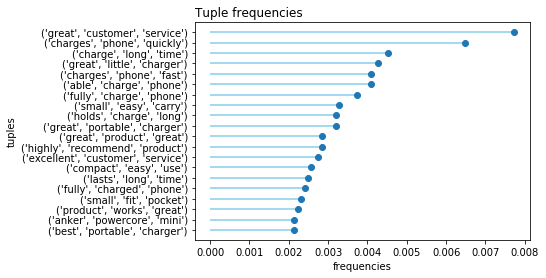

In [56]:
#Visualizing top positive Cellphones specific product
VisualizingTopTuples(0,spacy_cellphones_spec_top_positive)

#### In this case, the results we got are inconclusive as some of the tuples are of a positive nature, e.g, ('hold', 'charge', 'long').

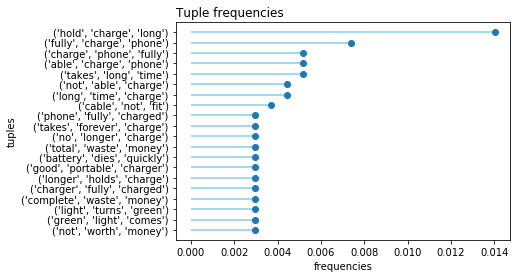

In [57]:
#Visualizing top negative Cellphones specific product
VisualizingTopTuples(1,spacy_cellphones_spec_top_negative)

#### Some combinations appear in both lists, the positive and the negative, and even in the top lists, like the tuples ('fully', 'charge', 'phone') and ('able', 'charge', 'phone').

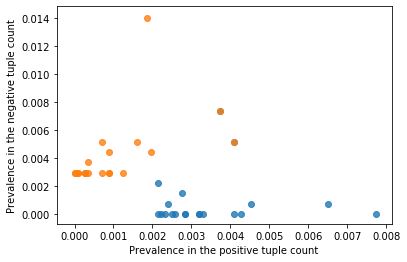

In [58]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Cellphones dictionaries
VisualizingTopTuplesNegative_Positive(spacy_cellphones_spec_top_positive,spacy_cellphones_spec_top_negative)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Electronics

In [59]:
#Loading Electronics specific product data

electronics_spec_df = pd.read_pickle("Electronics\spacy\specific\electronics_specific_product.pickle")
electronics_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B00004T8R2,I bought these to use on my computer at work a...,5.0,NaN,"[[i, bought, these, to, use, on, my, computer,..."
1,B00004T8R2,These are the best portable headphones in this...,4.0,NaN,"[[these, are, the, best, portable, headphones,..."
2,B00004T8R2,"If you want value for your money, if you lose ...",5.0,NaN,"[[if, you, want, value, for, your, money, if, ..."
3,B00004T8R2,You don't get a better headphone for five buck...,5.0,NaN,"[[you, do, not, get, a, better, headphone, for..."
4,B00004T8R2,"For such a cheap little thing, bass sounds goo...",4.0,NaN,"[[for, such, a, cheap, little, thing, bass, so..."


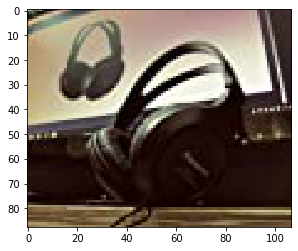

In [60]:
#Displaying product image

electronics_image_df = electronics_spec_df.dropna(subset=['image'])
electronics_image_df = electronics_image_df.reset_index()

response = requests.get(electronics_image_df.image[0][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [61]:
#Dataset containing reviews with high rate only
electronics_spec_pos_df = electronics_spec_df[electronics_spec_df.overall > 3]
electronics_spec_pos_df= electronics_spec_pos_df.reset_index()
print(electronics_spec_pos_df.shape[0])

3382


In [62]:
#Dataset containing reviews with low rate only
electronics_spec_neg_df = electronics_spec_df[electronics_spec_df.overall < 3]
electronics_spec_neg_df= electronics_spec_neg_df.reset_index()
print(electronics_spec_neg_df.shape[0])

455


In [63]:
#Loading Electronics specific product dictionary positive files
with open('Electronics/spacy/specific/electronics_specific_product_spacy_positive_tuples_count.txt',mode='r') as pos_file:
    spacy_electronics_spec_pos_tuples_count = json.load(pos_file)

In [64]:
#Loading Electronics specific product dictionary negative files 
with open('Electronics/spacy/specific/electronics_specific_product_spacy_negative_tuples_count.txt',mode='r') as neg_file:
    spacy_electronics_spec_neg_tuples_count = json.load(neg_file)

In [65]:
#The tuples that appear relatively more in positive reviews and negative reviews
electronics_spec_pos_amount_reviews= electronics_spec_pos_df.shape[0]
electronics_spec_neg_amount_reviews= electronics_spec_neg_df.shape[0]
spacy_electronics_spec_top_positive, spacy_electronics_spec_top_negative = TopList(spacy_electronics_spec_pos_tuples_count,spacy_electronics_spec_neg_tuples_count,electronics_spec_pos_amount_reviews,electronics_spec_neg_amount_reviews,20)

In [66]:
spacy_electronics_spec_top_positive

[("('good', 'sound', 'quality')", (0.01655824955647546, 0.002197802197802198)),
 ("('sound', 'quality', 'good')",
  (0.014192785334121822, 0.002197802197802198)),
 ("('great', 'sound', 'quality')",
  (0.006505026611472502, 0.002197802197802198)),
 ("('sound', 'quality', 'great')", (0.005322294500295683, 0.0)),
 ("('good', 'sound', 'price')", (0.005026611472501478, 0.002197802197802198)),
 ("('sound', 'quality', 'excellent')", (0.004435245416913069, 0.0)),
 ("('sound', 'great', 'price')", (0.004435245416913069, 0.0)),
 ("('decent', 'sound', 'quality')", (0.004139562389118865, 0.0)),
 ("('headphones', 'sound', 'good')", (0.004139562389118865, 0.0)),
 ("('excellent', 'sound', 'quality')", (0.00384387936132466, 0.0)),
 ("('sound', 'quality', 'better')", (0.0035481963335304554, 0.0)),
 ("('but', 'sound', 'quality')", (0.003252513305736251, 0.0)),
 ("('headphones', 'sound', 'great')", (0.003252513305736251, 0.0)),
 ("('great', 'sound', 'great')", (0.003252513305736251, 0.0)),
 ("('sound', 'q

In [67]:
spacy_electronics_spec_top_negative

[("('poor', 'sound', 'quality')", (0.0, 0.008791208791208791)),
 ("('spend', 'extra', 'bucks')", (0.0, 0.006593406593406593)),
 ("('not', 'good', 'sound')", (0.00029568302779420464, 0.006593406593406593)),
 ("('sound', 'quality', 'ok')", (0.0008870490833826139, 0.006593406593406593)),
 ("('low', 'price', 'not')", (0.0008870490833826139, 0.006593406593406593)),
 ("('cheap', 'set', 'headphones')",
  (0.0020697811945594325, 0.006593406593406593)),
 ("('headphones', 'not', 'fit')", (0.0, 0.006593406593406593)),
 ("('sound', 'quality', 'fine')",
  (0.00029568302779420464, 0.006593406593406593)),
 ("('sound', 'quality', 'poor')", (0.0, 0.006593406593406593)),
 ("('total', 'waste', 'money')", (0.0, 0.004395604395604396)),
 ("('cheap', 'pair', 'headphones')",
  (0.0026611472501478417, 0.004395604395604396)),
 ("('better', 'headphones', 'dollar')",
  (0.00029568302779420464, 0.004395604395604396)),
 ("('larger', 'hat', 'size')", (0.0, 0.004395604395604396)),
 ("('great', 'reviews', 'but')", (0.

#### We got some good results, we can assume that the product has good sound quality.

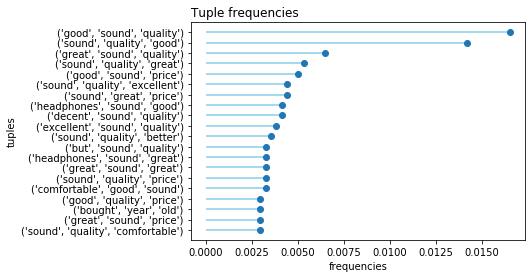

In [68]:
#Visualizing top positive Electronics specific product
VisualizingTopTuples(0,spacy_electronics_spec_top_positive)

#### We are getting nice results here as well, such as ('poor', 'sound', 'quality') although controversy to the top positive results.

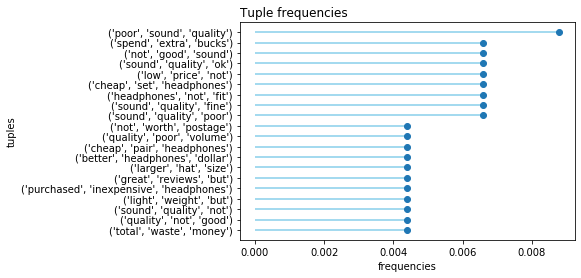

In [69]:
#Visualizing top negative Electronics specific product
VisualizingTopTuples(1,spacy_electronics_spec_top_negative)

#### The positive and negative tuples overlap. But there are no identical tuples in top lists

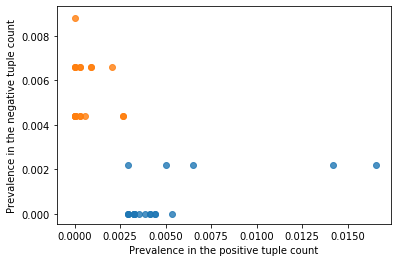

In [70]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Electronics dictionaries
VisualizingTopTuplesNegative_Positive(spacy_electronics_spec_top_positive,spacy_electronics_spec_top_negative)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Automotive

In [71]:
#Loading Automotive specific product data

automotive_spec_df = pd.read_pickle("Automotive/spacy/specific/automotive_specific_product.pickle")
automotive_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B0000AY3X0,This thing is superior to any chamois I have e...,5.0,NaN,"[[this, thing, is, superior, to, any, chamois,..."
1,B0000AY3X0,No more wet dog towels to dry. Its curious ho...,5.0,NaN,"[[no, more, wet, dog, towels, to, dry], [its, ..."
2,B0000AY3X0,I wash my vehicle's a lot and used to buy a ne...,5.0,NaN,"[[i, wash, my, vehicles, a, lot, and, used, to..."
3,B0000AY3X0,At my job we transport all levels of VIP and t...,5.0,NaN,"[[at, my, job, we, transport, all, levels, of,..."
4,B0000AY3X0,This chamois worked very well in comparison to...,4.0,NaN,"[[this, chamois, worked, very, well, in, compa..."


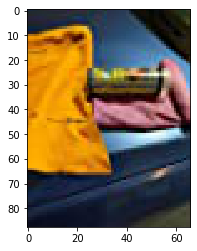

In [72]:
#Displaying product image

automotive_image_df = automotive_spec_df.dropna(subset=['image'])
automotive_image_df = automotive_image_df.reset_index()

response = requests.get(automotive_image_df.image[0][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [73]:
#Dataset containing reviews with high rate only
automotive_spec_pos_df = automotive_spec_df[automotive_spec_df.overall > 3]
automotive_spec_pos_df= automotive_spec_pos_df.reset_index()
print(automotive_spec_pos_df.shape[0])

1416


In [74]:
#Dataset containing reviews with low rate only
automotive_spec_neg_df = automotive_spec_df[automotive_spec_df.overall < 3]
automotive_spec_neg_df = automotive_spec_neg_df.reset_index()
print(automotive_spec_neg_df.shape[0])

104


In [75]:
#Loading Automotive specific product dictionary positive files
with open('Automotive/spacy/specific/automotive_specific_product_spacy_positive_tuples_count.txt',mode='r') as pos_file:
    spacy_automotive_spec_pos_tuples_count = json.load(pos_file)

In [76]:
#Loading Automotive specific product dictionary negative files 
with open('Automotive/spacy/specific/automotive_specific_product_spacy_negative_tuples_count.txt',mode='r') as neg_file:
    spacy_automotive_spec_neg_tuples_count = json.load(neg_file)

In [77]:
#The tuples that appear relatively more in positive reviews and negative reviews
automotive_spec_pos_amount_reviews = automotive_spec_pos_df.shape[0]
automotive_spec_neg_amount_reviews = automotive_spec_neg_df.shape[0]
spacy_automotive_spec_top_positive, spacy_automotive_spec_top_negative = TopList(spacy_automotive_spec_pos_tuples_count,spacy_automotive_spec_neg_tuples_count,automotive_spec_pos_amount_reviews,automotive_spec_neg_amount_reviews,20)

In [78]:
spacy_automotive_spec_top_positive

[("('bought', 'years', 'ago')", (0.009180790960451978, 0.0)),
 ("('way', 'dry', 'car')", (0.0049435028248587575, 0.009615384615384616)),
 ("('use', 'dry', 'car')", (0.00423728813559322, 0.009615384615384616)),
 ("('use', 'dry', 'cars')", (0.00423728813559322, 0.0)),
 ("('dry', 'car', 'off')", (0.00423728813559322, 0.0)),
 ("('best', 'drying', 'towel')", (0.0035310734463276836, 0.0)),
 ("('purchased', 'years', 'ago')", (0.0035310734463276836, 0.0)),
 ("('dry', 'cars', 'washing')", (0.0035310734463276836, 0.0)),
 ("('use', 'dry', 'off')", (0.0035310734463276836, 0.0)),
 ("('great', 'drying', 'car')", (0.0035310734463276836, 0.0)),
 ("('best', 'way', 'dry')", (0.0035310734463276836, 0.009615384615384616)),
 ("('good', 'drying', 'car')", (0.0035310734463276836, 0.009615384615384616)),
 ("('dry', 'car', 'washing')", (0.0035310734463276836, 0.009615384615384616)),
 ("('absorber', 'years', 'ago')", (0.002824858757062147, 0.0)),
 ("('lasts', 'long', 'time')", (0.002824858757062147, 0.0)),
 ("(

In [79]:
spacy_automotive_spec_top_negative

[("('read', 'positive', 'reviews')", (0.0, 0.019230769230769232)),
 ("('regular', 'microfiber', 'towel')", (0.0, 0.019230769230769232)),
 ("('towel', 'better', 'job')", (0.0, 0.019230769230769232)),
 ("('cotton', 'towel', 'better')", (0.0, 0.019230769230769232)),
 ("('not', 'dry', 'cars')", (0.0, 0.019230769230769232)),
 ("('use', 'dry', 'car')", (0.00423728813559322, 0.009615384615384616)),
 ("('takes', 'forever', 'sticks')", (0.0, 0.009615384615384616)),
 ("('better', 'advanced', 'auto')", (0.0, 0.009615384615384616)),
 ("('local', 'auto', 'store')", (0.0, 0.009615384615384616)),
 ("('old', 'tshirt', 'better')", (0.0, 0.009615384615384616)),
 ("('fine', 'job', 'absorbing')", (0.0, 0.009615384615384616)),
 ("('took', 'twice', 'time')", (0.0, 0.009615384615384616)),
 ("('drying', 'towel', 'poor')", (0.0, 0.009615384615384616)),
 ("('smaller', 'beads', 'smaller')", (0.0, 0.009615384615384616)),
 ("('quickly', 'dry', 'hair')", (0.0, 0.009615384615384616)),
 ("('regular', 'terry', 'towel'

#### We can tell from the results that the product is great for drying cars and lasts for a long time.

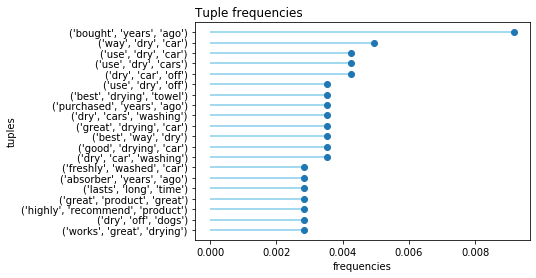

In [80]:
#Visualizing top positive Automotive specific product
VisualizingTopTuples(0,spacy_automotive_spec_top_positive)

#### In controversy to the top positive results, We can tell from the negative results that the product does not dry cars well and also might leave streaks.

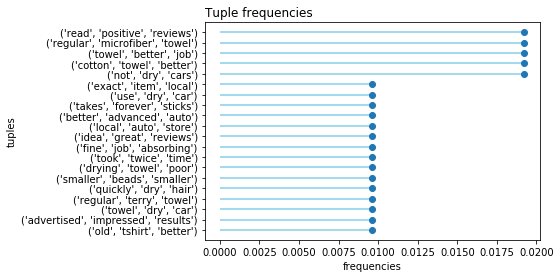

In [81]:
#Visualizing top negative Automotive specific product
VisualizingTopTuples(1,spacy_automotive_spec_top_negative)

#### There's an overlap between the positive combinations and the negative combinations, like the tuple ('use', 'dry', 'car').

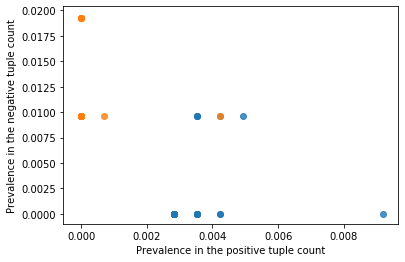

In [82]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Automotive dictionaries
VisualizingTopTuplesNegative_Positive(spacy_automotive_spec_top_positive,spacy_automotive_spec_top_negative)

<br>
<br>

_______________________________________________________________________________________________________________________________

<br>

### A few moments before we compare spacy to word2vec. <br>Let's look at another way we tried using spacy to find the properties.

#### We used the  Spacy regular expressions mechanism. This way, can build regular expressions that incorporate the varied text analyzes offered by Spacy
#### Compared to using regular expressions on raw text, spaCy’s rule-based matcher engines and components not only let us find the words and phrases we are looking for – they also give us access to the tokens within the document and their relationships. in this way we can easily access and analyze the surrounding tokens, merge spans into single tokens or add entries to the named entities in doc.ents.

<br>

##### The full notebook is attached to the files

In [89]:
#ourstopword contains stopwords without negative words 
OUR_STOP_WORDS = STOP_WORDS

for i in ['except','not','cannot','nor','nothing','neither','none','no','never','off','nowhere','but','however','else','nobody','empty']:
    OUR_STOP_WORDS.remove(i)

In [90]:
#In this way we define specific treatment for "..." punctuation.
#The appearance of this punctuation is considered to be the end of a sentence
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == "...":
            doc[token.i+1].is_sent_start = True
    return doc

In [91]:
nlp.add_pipe(set_custom_boundaries, before="parser")
from spacy.matcher import Matcher

In [92]:
#fun that cleaning the sentence
def cleanReview(review):
    
    #Elected to keep punctuation marks that define termination of sentence
    exept= set([',','.','!','?'])
    #Return a processed Doc for this review
    doc = nlp(review)
    #Use Spacy to identify punctuation marks in a review
    all_punct = set([token.text for token in doc if token.pos_=='PUNCT'])
    all_punct=all_punct-exept
    #Using Spacy for exchange words in a review to their basic forms
    review= [token.text if token.lemma_=="-PRON-" else token.lemma_ for token in doc ]
    #Get rid of unnecessary punctuation using the Spacy punctuation recognition function
    review= [word for word in review if word not in all_punct]
    #Remove any extra white space
    review = ' '.join(review)
    review= review.split()
    #Remove stopWords except negative words
    list_rev= [word for word in review if not word in set(OUR_STOP_WORDS)]
    review = " ".join(list_rev)
    
    return review

In [93]:
#Function returns all matches tuples that match the regular expressions we added to the Matcher
def getReviewTuple(review,matcher):

    review=cleanReview(review)
    doc = nlp(review)
    matches = matcher(doc)
    
    review_tuple= set()
    
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        review_tuple.add(tuple((span.text).split()))
        
    return review_tuple

In [94]:
#Function that returns a dictionary whose keys are sequences with adjectives-adverb and noun
#The value of each key is the number of times it appears in all the reviews
def getDictionaryAdvAndAdj2(reviews):

    tuples_count={}
    log_message=10000
    
    #initializing the Matcher with a vocab. The matcher must always share the same vocab with the documents it will operate on
    matcher = Matcher(nlp.vocab)

    #adding ID="tuple" and our custom pattern
    matcher.add("tuple", None,
           [{"TEXT": "like"},{"POS":"NOUN","OP":"+"}], 
           [{"TEXT": "not","OP": "?"},{"POS": "ADV","OP": "+"},{"POS": "PROPN","OP":"?"},{"POS": "NOUN"}],
           [{"TEXT": "not","OP": "?"},{"POS": "ADJ","OP": "+"},{"POS": "PROPN","OP":"?"},{"POS": "NOUN"}],
           [{"TEXT": "not","OP": "?"},{"POS": "PROPN","OP":"?"},{"POS": "NOUN"},{"POS": "ADJ","OP": "+"}])

    for i,review in enumerate(reviews):

        if i%log_message ==0:
            print("log_message: ",i)

        review_tuples= getReviewTuple(review,matcher)

        for word_tup in review_tuples:
            tuples_count[word_tup]= tuples_count.get(word_tup,0)+1

    return tuples_count

#### STEPS:
##### -All reviews in their original form were sent to the getDictionaryAdvAndAdj function.
##### -This function declares and initializes Matcher, Matcher actually: Match sequences of tokens, based on pattern rules.<br>for more information about the matcher: [matcher](https://spacy.io/api/matcher) 
##### -The function sends a review and the Matcher that is initialized, To the function getReviewTuples which clears every review and pulls out all matches found by the Matcher

In [97]:
positive_tuples_count={}
with open('regular_exp/regular_electronics_spacy_positive_tuples_count.txt',mode='r') as f:
            positive_tuples_count = json.load(f)   

In [98]:
with open('regular_exp/regular_electronics_spacy_negative_tuples_count.txt',mode='r') as f:
            negative_tuples_count = json.load(f)

In [100]:
#Creating a dictionary whose key is a tuple.
#the value of each key is a set that contains the incidence of the tuple in positive responses, and negative responses
all_tuples= set(positive_tuples_count)|set(negative_tuples_count)

tuple_scores = {}

for word_tup in all_tuples:
    positive_score=positive_tuples_count.get(word_tup,0)/df_positive_reviews.shape[0]
    negative_score=negative_tuples_count.get(word_tup,0)/df_negative_reviews.shape[0]
    tuple_scores[word_tup]=(positive_score,negative_score)

In [101]:
#The tuples that appear relatively more in positive reviews
regular_electronics_top_positive= sorted(tuple_scores.items(),key = lambda t: t[1][0], reverse = True)[:20]

#The tuples that appear relatively more in negative reviews
regular_electronics_top_negative= sorted(tuple_scores.items(),key = lambda t: t[1][1], reverse = True)[:20]

In [102]:
regular_electronics_top_positive

[("('easy', 'use')", (0.01588442895521729, 0.0033815126910698634)),
 ("('sound', 'quality')", (0.012895690529396564, 0.012932606484058582)),
 ("('great', 'product')", (0.012258144937095934, 0.0016155760728384873)),
 ("('great', 'price')", (0.009871893588316945, 0.001006135989916246)),
 ("('good', 'quality')", (0.007995613790202053, 0.0024425590724993763)),
 ("('good', 'price')", (0.007889139780897265, 0.0016235739741891728)),
 ("('high', 'quality')", (0.006758502663797928, 0.0036422442751022134)),
 ("('good', 'product')", (0.006441028331175719, 0.002428162850068142)),
 ("('easy', 'install')", (0.006361172824197127, 0.0008477775431726715)),
 ("('work', 'great')", (0.006270280377229624, 0.003141575650549296)),
 ("('hard', 'drive')", (0.005599299349080234, 0.0058896545546448615)),
 ("('year', 'old')", (0.005010121523201596, 0.005051474493093012)),
 ("('long', 'time')", (0.004892935189789922, 0.003146374391359707)),
 ("('great', 'sound')", (0.004548193123077462, 0.0012316768080055792)),
 (

In [103]:
regular_electronics_top_negative

[("('sound', 'quality')", (0.012895690529396564, 0.012932606484058582)),
 ("('hard', 'drive')", (0.005599299349080234, 0.0058896545546448615)),
 ("('year', 'old')", (0.005010121523201596, 0.005051474493093012)),
 ("('poor', 'quality')", (0.0003405220602461108, 0.004997088763908351)),
 ("('brand', 'new')", (0.0016685256336177402, 0.004202097369650204)),
 ("('high', 'quality')", (0.006758502663797928, 0.0036422442751022134)),
 ("('easy', 'use')", (0.01588442895521729, 0.0033815126910698634)),
 ("('long', 'time')", (0.004892935189789922, 0.003146374391359707)),
 ("('work', 'great')", (0.006270280377229624, 0.003141575650549296)),
 ("('good', 'thing')", (0.0027072964561034927, 0.002981617623535584)),
 ("('work', 'fine')", (0.0012410065169884475, 0.002770473027877485)),
 ("('worth', 'money')", (0.0033188727778419797, 0.0026233116430248705)),
 ("('different', 'brand')", (0.0005911255211707986, 0.002591320037622128)),
 ("('good', 'luck')", (0.000826472035640227, 0.0025433326295180147)),
 ("('

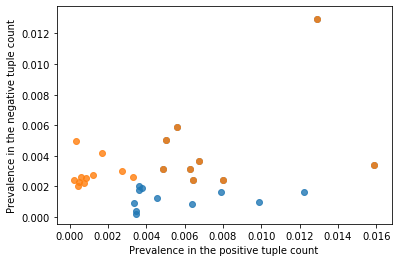

In [104]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Automotive dictionaries
VisualizingTopTuplesNegative_Positive(regular_electronics_top_positive,regular_electronics_top_negative)

#### The positive combinations are great, but the big problem is that the negative combinations look the same as the positive combinations.<br>The reason is that the regular combination has a question mark before NOT so that if NOT appears in the sentence.<br> The Matcher will take both options with and without NOT. We tried to change the phrase but encountered another problem of OVER FITTING.

_______________________________________________________________________________________________________________________________

<br>

## Spacy Conclusions:

#### For the specific products of Electronics and Automotive, the positive and negative common combinations collided with each other and no positive and negative characteristics could be deduced for the same products.<br>A similar situation also happened in Word2vec, which could indicate that there is a disagreement between them.
#### Spacy is a very powerful library, we touched the tip of the iceberg.<br>Our attempts to go deeper and experiment with regular expressions have not been a huge success, but they are a good direction to continue to explore.

<br>

_______________________________________________________________________________________________________________________________

# Now it is time to compare the two main approaches.<br>
### We will compare the different category results. And we <br>will also compare the specific products results

<br>

In [105]:
#Displaying the prevalence for each top 20 tuples in spacy and word2vec dictionaries
def VisualizingTopTuples_Word2Vec_SpaCy(top_spacy,top_word2vec,pos_or_neg,word2vec_tuples_count,spacy_tuples_count,amount_rev):
    
    Xspacy_spacy = [tup[1][pos_or_neg] for tup in top_spacy]
    Yword2vec_spacy = [(word2vec_tuples_count.get(tup[0],0)/amount_rev) for tup in top_spacy]

    Xspacy_word2vec = [(spacy_tuples_count.get(tup[0],0)/amount_rev) for tup in top_word2vec]
    Yword2vec_word2vec = [tup[1][pos_or_neg] for tup in top_word2vec]

    plt.xlabel('Prevalence in the spacy tuple count')
    plt.ylabel('Prevalence in the word2vec tuple count')
    
    sns.regplot(x=Xspacy_spacy, y=Yword2vec_spacy, fit_reg=False)
    sns.regplot(x=Xspacy_word2vec, y=Yword2vec_word2vec, fit_reg=False)

    plt.show()

<br>

## Comparison of Word2vec and SpaCy Electronics

### Comparing Spacy with Word2vec in the Electronic Category

In [106]:
#Loading Electronics dictionary positive and negative files
with open('Electronics/word2vec/electronics_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_electronics_positive_tuples_count = json.loads(json.load(pos_file))
with open('Electronics/word2vec/electronics_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_electronics_negative_tuples_count = json.loads(json.load(neg_file)) 

#Loading Electronics dictionary top positive and negative files
with open('Electronics/word2vec/top20/electronics_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_electronics_top_positive = json.load(pos_file)
with open('Electronics/word2vec/top20/electronics_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_electronics_top_negative = json.load(neg_file)

#### We can see that most of the positive Word2Vec tuples are also appears in the positive Spacy tuples.

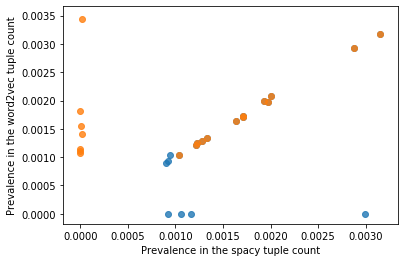

In [107]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_electronics_top_positive,word2vec_electronics_top_positive,0,word2vec_electronics_positive_tuples_count,spacy_electronics_positive_tuples_count,electronics_amount_positive_reviews)

#### There is a slight divergence between the results of the approaches but the majority overlaps.

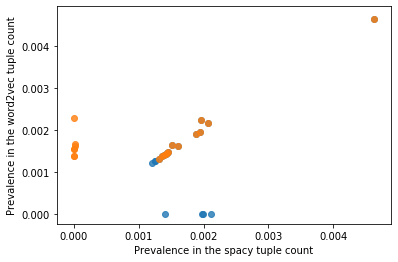

In [108]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_electronics_top_negative,word2vec_electronics_top_negative,1,word2vec_electronics_negative_tuples_count,spacy_electronics_negative_tuples_count,electronics_amount_negative_reviews)

### Comparing Spacy with Word2vec in the Electronic specific product

In [109]:
#Loading Electronics specific product dictionary positive and negative files
with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_electronics_spec_positive_tuples_count = json.loads(json.load(pos_file))
with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_electronics_spec_negative_tuples_count = json.loads(json.load(neg_file)) 
    
#Loading Electronics specific product dictionary top positive and negative files
with open('Electronics/word2vec/specific/top20/electronics_specific_product_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_electronics_spec_top_positive = json.load(pos_file)
with open('Electronics/word2vec/specific/top20/electronics_specific_product_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_electronics_spec_top_negative = json.load(neg_file)

#### As we see, most of the top positive Word2Vec tuples are also appears in the top positive Spacy tuples.

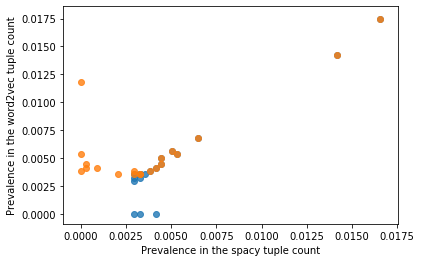

In [110]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_electronics_spec_top_positive,word2vec_electronics_spec_top_positive,0,word2vec_electronics_spec_positive_tuples_count,spacy_electronics_spec_pos_tuples_count,electronics_spec_pos_amount_reviews)

#### As we see here as well, most of the negaitive Word2Vec tuples are also appears in the negative Spacy tuples.

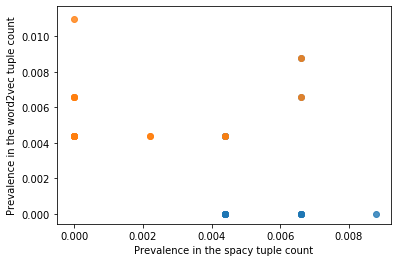

In [111]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_electronics_spec_top_negative,word2vec_electronics_spec_top_negative,1,word2vec_electronics_spec_negative_tuples_count,spacy_electronics_spec_neg_tuples_count,electronics_spec_neg_amount_reviews)

#### There is an overlap between the top tuples of the specific electronic product in both approaches<br> We can find most of the Word2Vec top tuples as part of spacy top tuples.

#### (Liat) It is evident that there is very little overlap between the Top tuples of the specific electronic product in both approaches<br>Most tuples do not overlap

<br>
<br>


## Comparison of Word2vec and SpaCy Cellphones

### Comparing Spacy with Word2vec in the Cellphones Category

In [112]:
#Loading Cellphones dictionary positive and negative files  
with open('Cellphones/word2vec/cellphone_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_cellphones_positive_tuples_count = json.loads(json.load(pos_file))
with open('Cellphones/word2vec/cellphone_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_cellphones_negative_tuples_count = json.loads(json.load(neg_file))

#Loading Cellphones dictionary top positive and negative files  
with open('Cellphones/word2vec/top20/cellphones_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_cellphones_top_positive = json.load(pos_file)
with open('Cellphones/word2vec/top20/cellphones_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_cellphones_top_negative = json.load(neg_file)

#### We can see that most of the top positive Word2Vec tuples are also appears in the top positive Spacy tuples, and vice versa.

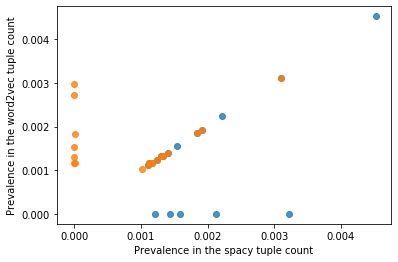

In [113]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_cellphones_top_positive,word2vec_cellphones_top_positive,0,word2vec_cellphones_positive_tuples_count,spacy_cellphones_positive_tuples_count,cellphones_amount_positive_reviews)

#### It is evident that most of the top negative of Word2Vec tuples are also appears in the top negaitive of Spacy tuples.

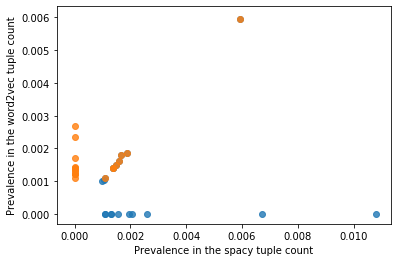

In [114]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_cellphones_top_negative,word2vec_cellphones_top_negative,1,word2vec_cellphones_negative_tuples_count,spacy_cellphones_negative_tuples_count,cellphones_amount_negative_reviews)

### Comparing Spacy with Word2vec in the Cellphones specific product

In [115]:
#Loading Cellphones specific product dictionary positive and negative files
with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_cellphones_spec_positive_tuples_count = json.loads(json.load(pos_file))
with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_cellphones_spec_negative_tuples_count = json.loads(json.load(neg_file)) 

#Loading Cellphones specific product dictionary top positive and negative files
with open('Cellphones/word2vec/specific/top20/cellphones_specific_product_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_cellphones_spec_top_positive = json.load(pos_file)
with open('Cellphones/word2vec/specific/top20/cellphones_specific_product_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_cellphones_spec_top_negative = json.load(neg_file)

#### It is evident that most of the top positive Word2Vec tuples are also appears in the top positive Spacy tuples.

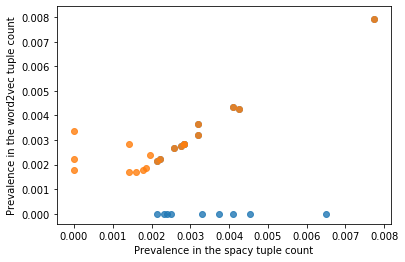

In [116]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_cellphones_spec_top_positive,word2vec_cellphones_spec_top_positive,0,word2vec_cellphones_spec_positive_tuples_count,spacy_cellphones_spec_pos_tuples_count,cellphones_spec_pos_amount_reviews)

#### In this case, in most combinations, there is no overlap between Spacy to Word2Vec

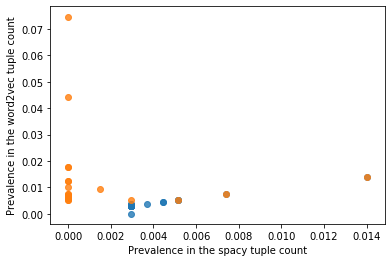

In [117]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_cellphones_spec_top_negative,word2vec_cellphones_spec_top_negative,1,word2vec_cellphones_spec_negative_tuples_count,spacy_cellphones_spec_neg_tuples_count,cellphones_spec_neg_amount_reviews)

<br>
<br>
<br>

## Comparison of Word2vec and SpaCy Automotive

### Comparing Spacy with Word2vec in the Automotive Category

In [118]:
#Loading Automotive dictionary positive and negative files
with open('Automotive/word2vec/automotive_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_automotive_positive_tuples_count = json.loads(json.load(pos_file))
with open('Automotive/word2vec/automotive_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_automotive_negative_tuples_count = json.loads(json.load(neg_file))
    
#Loading Automotive dictionary top positive and negative files
with open('Automotive/word2vec/top20/automotive_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_automotive_top_positive = json.load(pos_file)
with open('Automotive/word2vec/top20/automotive_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_automotive_top_negative = json.load(neg_file)  

#### Here, most Spacy positive combinations do not appear in the positive combinations of Word2vec.<br>but on the contrary, there is overlap.

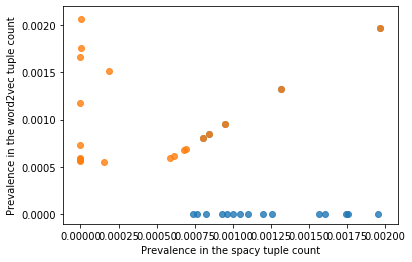

In [119]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_automotive_top_positive,word2vec_automotive_top_positive,0,word2vec_automotive_positive_tuples_count,spacy_automotive_positive_tuples_count,automotive_amount_positive_reviews)

#### Here as well, some of the top positive Word2Vec tuples are also appears in the top positive Spacy tuples.

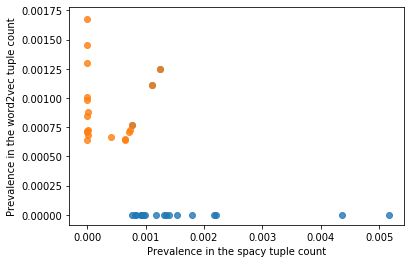

In [120]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_automotive_top_negative,word2vec_automotive_top_negative,1,word2vec_automotive_negative_tuples_count,spacy_automotive_negative_tuples_count,automotive_amount_negative_reviews)

### Comparing Spacy with Word2vec in the Cellphones specific product

In [121]:
#Loading Automotive specific product dictionary positive and negative files
with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    word2vec_automotive_spec_positive_tuples_count = json.loads(json.load(pos_file))
with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    word2vec_automotive_spec_negative_tuples_count = json.loads(json.load(neg_file))
    
#Loading Automotive specific product dictionary top positive and negative files
with open('Automotive/word2vec/specific/top20/automotive_specific_product_word2vec_positive_Top20_tuples_count.txt',mode='r') as pos_file:
    word2vec_automotive_spec_top_positive = json.load(pos_file)
with open('Automotive/word2vec/specific/top20/automotive_specific_product_word2vec_negative_Top20_tuples_count.txt',mode='r') as neg_file:
    word2vec_automotive_spec_top_negative = json.load(neg_file)  

#### We can see that there's a minor overlap between the top positive Word2Vec tuples and the top positive Spacy tuples.

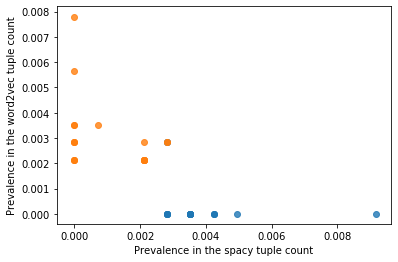

In [122]:
#Visualization The prevalence of positive tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_automotive_spec_top_positive,word2vec_automotive_spec_top_positive,0,word2vec_automotive_spec_positive_tuples_count,spacy_automotive_spec_pos_tuples_count,automotive_spec_pos_amount_reviews)

#### We can see that there's an overlap between the top negative Word2Vec tuples and the top negative Spacy tuples

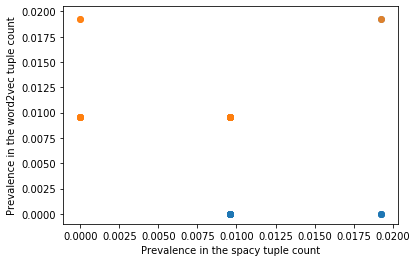

In [123]:
#Visualization The prevalence of negative tuples in spacy and word2vec
VisualizingTopTuples_Word2Vec_SpaCy(spacy_automotive_spec_top_negative,word2vec_automotive_spec_top_negative,1,word2vec_automotive_spec_negative_tuples_count,spacy_automotive_spec_neg_tuples_count,automotive_spec_neg_amount_reviews)

<br>
<br>
<br>
<br>
<br>

_______________________________________________________________________________________________________________________________

# Summary

#### Both methods had good results in most cases.<br>word2vec found clearer negative expressions in most cases,<br> but Spacy had better performance than word2vec in the positive characteristics that seem more interesting and less general.

#### We decided to take size 3 combinations<br>To include the following options:<br><br>     - The appearance of an additional adjective<br>     - adjective before or after the noun.<br>     - PROPN might appear before the noun

#### The characteristics turned out quite interesting in most cases but we have no doubt that they can still get better

#### We think that if we would've taken reviews rated only in grades 1 and 5 then there was more polarity between negative and positive. we would come across less positive combinations that appear negative.

#### The Spacy library contains amazing tools, first, we experimented with various libraries like WordNet that did not deliver the goods that Spacy provided. We believe that continuing the focus on regular expressions mechanism can improve the results even more.

#### We think that perhaps a very interesting continuation study would be to examine the combination of the two methods.<br>It can lead to significant improvement.

#### The initial experience with Word2Vec and Spacy was challenging, fun and we learned a lot from it.



<br>

_______________________________________________________________________________________________________________________________